In [35]:
### Installing the required packages if not already installed
packages = ['numpy', 'pandas', 'warnings', 'sqlite3', 'scipy', 'matplotlib', 'numba']

for package in packages:
    try:
        __import__(package)
    except ImportError:
        %pip install {package}

import numpy as np    # For numerical computing
import pandas as pd   # For data manipulation
import sqlite3        # For connecting to SQL database
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.optimize import minimize
from scipy import stats
from numba import njit
import os

### Ignoring the warnings
import warnings
warnings.filterwarnings('ignore')

### Pandas display options
pd.options.display.float_format = '{:.4f}'.format

### Getting some fuctions from the other notebook
%run 99_functions.ipynb

### Setting working directory
os.chdir('/Users/emilwilliamhansen/Desktop/Master-Thesis/Code')

In [36]:
### Table to store our results in
latex_all_period = pd.DataFrame(columns=['UMV', 'CMV_k', 'CMV_m'])

                      UMV  CMV_k  CMV_m
Mean               0.3817 0.4881 0.4246
Standard deviation 0.2495 0.3164 0.2802
Sharpe ratio       1.5295 1.5424 1.5153
p-value               NaN 0.2756 0.0395
alpha                 NaN 2.9937 2.0999
t(alpha)              NaN 1.1059 0.7707


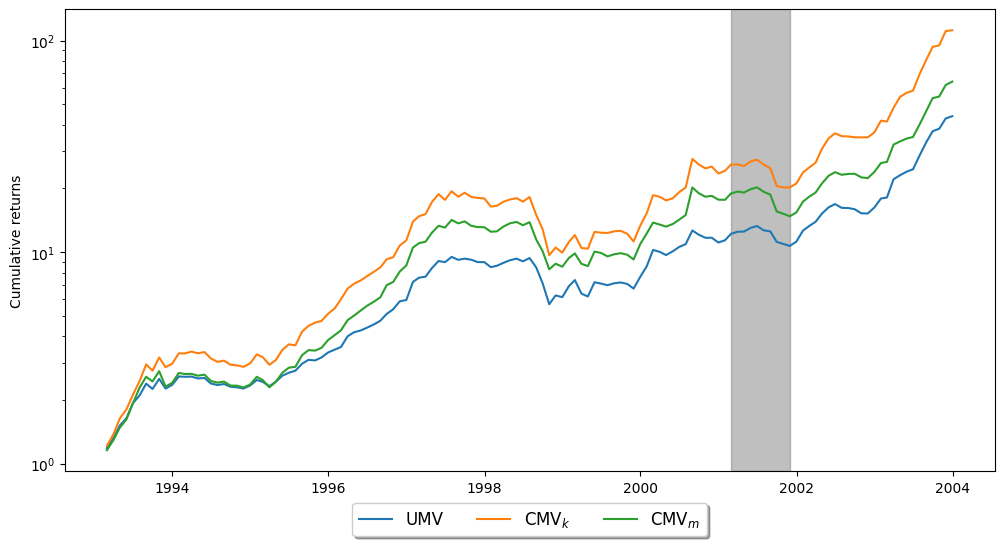

In [37]:
### Extracting the data from the database
conn = sqlite3.connect('Data/data.db')

factor_ret_m = pd.read_sql('SELECT * FROM factors_monthly', conn).set_index('Date').drop(columns='rf')
volatility = pd.read_sql('SELECT * FROM volatility', conn).set_index('Date')

conn.close()

### Making sure all the data is in the same format
factor_ret_m.index = pd.to_datetime(factor_ret_m.index)
volatility.index = pd.to_datetime(volatility.index)

### Fixing the index of the factor_ret_m
factor_ret_m = factor_ret_m.loc[volatility.index]

### Restricing the data to the period we want
factor_ret_m = factor_ret_m.loc[:'2003']
volatility = volatility.loc[:'2003']

### Calculating the optimal c for each factor
c = pd.DataFrame(columns=factor_ret_m.columns)
c.loc['c_fac', :] = np.nan
c.loc['c_mkt', :] = np.nan

for factor in factor_ret_m.columns:
    def obj_func(c):
        vol_timed = (c / volatility[factor]).shift(1) * factor_ret_m[factor]
        return (vol_timed.std() - factor_ret_m.iloc[1:,][factor].std())**2

    res = minimize(obj_func, 0.1)
    c.loc['c_fac', factor] = res.x[0]

for factor in factor_ret_m.columns:
    def obj_func(c):
        vol_timed = (c / volatility['VW']).shift(1) * factor_ret_m[factor]
        return (vol_timed.std() - factor_ret_m.iloc[1:,][factor].std())**2

    res = minimize(obj_func, 0.1)
    c.loc['c_mkt', factor] = res.x[0]

### Getting the volatility timed returns
r_sigma_k, r_sigma_m = pd.DataFrame(index=factor_ret_m.index, columns=factor_ret_m.columns), pd.DataFrame(index=factor_ret_m.index, columns=factor_ret_m.columns)

for factor in factor_ret_m.columns:
    r_sigma_k[factor] = (c.loc['c_fac', factor] / volatility[factor]).shift(1) * factor_ret_m[factor]
    r_sigma_m[factor] = (c.loc['c_mkt', factor] / volatility['VW']).shift(1) * factor_ret_m[factor]

### Dropping the first row in all of our returns
r_sigma_k = r_sigma_k.iloc[1:,]
r_sigma_m = r_sigma_m.iloc[1:,]
r = factor_ret_m.iloc[1:,]

### Defining the starting window size
window = 120

### Creating a place to store the returns
MV = pd.DataFrame(columns=[['UMV', 'CMV_k', 'CMV_m']], index=r.index).iloc[window:,]
MV_is = pd.DataFrame(columns=[['UMV', 'CMV_k', 'CMV_m']], index=r.index).iloc[window:,]

### Getting the data we need for the expanding window
data_o = r
data_m = pd.concat([r, r_sigma_m], axis=1)
data_k = pd.concat([r, r_sigma_k], axis=1)

### Getting the in-sample weights
w_o_is = ptf_weights(data_o.iloc[window:,], negative=False, type='MVP', gamma = 5, wanted_weight='None')
w_m_is = ptf_weights(data_m.iloc[window:,], negative=False, type='MVP', gamma = 5, wanted_weight='None')
w_k_is = ptf_weights(data_k.iloc[window:,], negative=False, type='MVP', gamma = 5, wanted_weight='None')

### Getting the in-sample returns
MV_is.loc[:, 'UMV'] = (w_o_is * data_o.iloc[window:,]).sum(axis=1)
MV_is.loc[:, 'CMV_m'] = (w_m_is * data_m.iloc[window:,]).sum(axis=1)
MV_is.loc[:, 'CMV_k'] = (w_k_is * data_k.iloc[window:,]).sum(axis=1)

### Running the loop
for i in range(window, len(r)):
    ## Getting the weights
    w_o = ptf_weights(data_o.iloc[:i,], negative=False, type='MVP', gamma = 5, wanted_weight='None')
    w_m = ptf_weights(data_m.iloc[:i,], negative=False, type='MVP', gamma = 5, wanted_weight='None')
    w_k = ptf_weights(data_k.iloc[:i,], negative=False, type='MVP', gamma = 5, wanted_weight='None')

    ## Getting the returns
    MV.loc[r.index[i], 'UMV'] = (w_o * r.iloc[i,]).sum()
    MV.loc[r.index[i], 'CMV_k'] = (w_m * data_k.iloc[i,]).sum()
    MV.loc[r.index[i], 'CMV_m'] = (w_k * data_m.iloc[i,]).sum()

### Getting the p-values
p_values = pd.DataFrame(columns=MV.columns, index=['In-Sample', 'Out-of-Sample'])

### Number of simulations
n_boot = 10000

### Getting the data we need
data = pd.concat([MV, MV_is], axis=1)

### Loop for in-sample or out-of-sample
for s in [0,1]:

    ### Loop for factor or market
    for f in [1,2]:

        ## Creating a list to store the differences
        diff = []

        ## Loop for the bootstrap
        for i in range(n_boot):
            # Getting the bootstrapped returns
            boot = stationary_bootstrap(np.array(data.iloc[:, [(0+s*3), (f+s*3)]].astype(float)), 5, len(data))

            # Adding the difference to the list
            diff.append(sharpes_ratio(boot[:,0]) - sharpes_ratio(boot[:,1]))

        ## Getting the p-value
        p_values.iloc[s,f] = (np.sum(np.array(diff) > 0) / (len(diff)))

### Getting the alphas
X = MV['UMV'].astype(float)
X = sm.add_constant(X)
y = MV['CMV_k'].astype(float)
model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':1})
alpha_k = model.params['const']
tstat_alpha_k = model.tvalues['const']

y = MV['CMV_m'].astype(float)
model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':1})
alpha_m = model.params['const']
tstat_alpha_m = model.tvalues['const']

### Creating  a latex table
latex = pd.DataFrame(columns=['UMV', 'CMV_k', 'CMV_m'], index=['Mean', 'Standard deviation', 'Sharpe ratio', 'p-value', 'alpha', 't(alpha)'])

latex.loc['Mean', :] = MV.mean().values * 12
latex.loc['Standard deviation', :] = MV.std().values * np.sqrt(12)
latex.loc['Sharpe ratio', :] = sharpes_ratio(MV).values
latex.loc['p-value', 'CMV_k'] = p_values.iloc[1,1]
latex.loc['p-value', 'CMV_m'] = p_values.iloc[1,2]
latex.loc['alpha', 'CMV_k'] = alpha_k * 12 * 100
latex.loc['alpha', 'CMV_m'] = alpha_m * 12 * 100
latex.loc['t(alpha)', 'CMV_k'] = tstat_alpha_k
latex.loc['t(alpha)', 'CMV_m'] = tstat_alpha_m

latex_all_period.loc['Sharpe ratio (1993-2003)', :] = sharpes_ratio(MV).values
latex_all_period.loc['p-value (1993-2003)', 'CMV_k'] = p_values.iloc[1,1]
latex_all_period.loc['p-value (1993-2003)', 'CMV_m'] = p_values.iloc[1,2]
latex_all_period.loc['alpha (1993-2003)', 'CMV_k'] = alpha_k * 12 * 100
latex_all_period.loc['alpha (1993-2003)', 'CMV_m'] = alpha_m * 12 * 100
latex_all_period.loc['t(alpha) (1993-2003)', 'CMV_k'] = tstat_alpha_k
latex_all_period.loc['t(alpha) (1993-2003)', 'CMV_m'] = tstat_alpha_m

#print(latex.to_latex(float_format="%.3f", na_rep=""))
print(latex)

### Plotting cumulative returns for all the 3 portfolios in MV
plt.figure(figsize=(12, 6))
plt.plot((1 + MV).cumprod())
plt.ylabel('Cumulative returns')
plt.legend(['UMV', r'CMV$_{k}$', r'CMV$_{m}$'], loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=3, fontsize='large')
plt.yscale('log')

recessions = [
    ('2001-03-01', '2001-11-30')
]

# Add grey fields for recessions
for start, end in recessions:
    plt.axvspan(start, end, color='grey', alpha=0.5)

plt.show()

                      UMV  CMV_k   CMV_m
Mean               0.8196 0.4461  0.5804
Standard deviation 0.4671 0.2816  0.3725
Sharpe ratio       1.7545 1.5839  1.5581
p-value               NaN 0.9607  0.9560
alpha                 NaN 6.2310 -2.0849
t(alpha)              NaN 0.8953 -0.5040


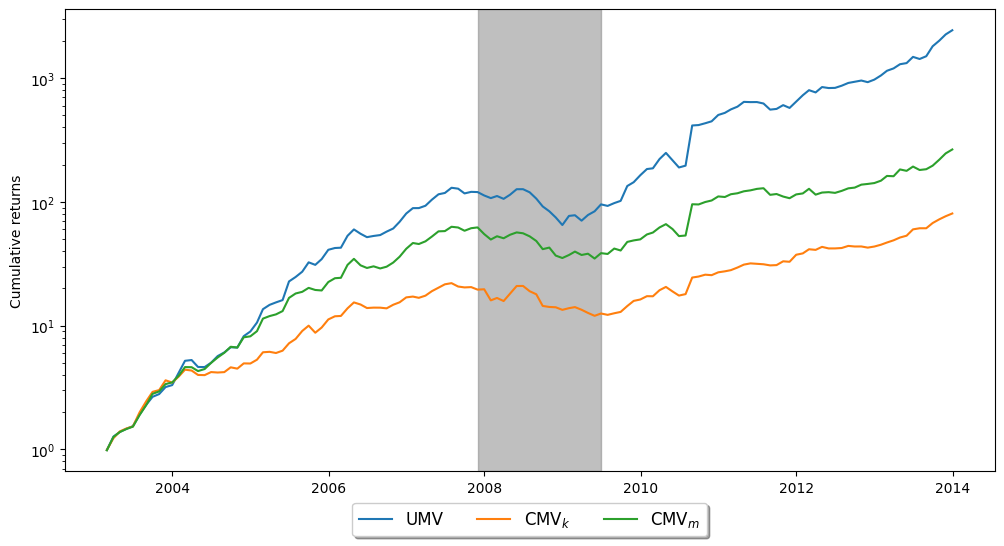

In [38]:
### Extracting the data from the database
conn = sqlite3.connect('Data/data.db')

factor_ret_m = pd.read_sql('SELECT * FROM factors_monthly', conn).set_index('Date').drop(columns='rf')
volatility = pd.read_sql('SELECT * FROM volatility', conn).set_index('Date')

conn.close()

### Making sure all the data is in the same format
factor_ret_m.index = pd.to_datetime(factor_ret_m.index)
volatility.index = pd.to_datetime(volatility.index)

### Fixing the index of the factor_ret_m
factor_ret_m = factor_ret_m.loc[volatility.index]

### Restricing the data to the period we want
factor_ret_m = factor_ret_m.loc['1993':'2013']
volatility = volatility.loc['1993':'2003']

### Calculating the optimal c for each factor
c = pd.DataFrame(columns=factor_ret_m.columns)
c.loc['c_fac', :] = np.nan
c.loc['c_mkt', :] = np.nan

for factor in factor_ret_m.columns:
    def obj_func(c):
        vol_timed = (c / volatility[factor]).shift(1) * factor_ret_m[factor]
        return (vol_timed.std() - factor_ret_m.iloc[1:,][factor].std())**2

    res = minimize(obj_func, 0.1)
    c.loc['c_fac', factor] = res.x[0]

for factor in factor_ret_m.columns:
    def obj_func(c):
        vol_timed = (c / volatility['VW']).shift(1) * factor_ret_m[factor]
        return (vol_timed.std() - factor_ret_m.iloc[1:,][factor].std())**2

    res = minimize(obj_func, 0.1)
    c.loc['c_mkt', factor] = res.x[0]

### Getting the volatility timed returns
r_sigma_k, r_sigma_m = pd.DataFrame(index=factor_ret_m.index, columns=factor_ret_m.columns), pd.DataFrame(index=factor_ret_m.index, columns=factor_ret_m.columns)

for factor in factor_ret_m.columns:
    r_sigma_k[factor] = (c.loc['c_fac', factor] / volatility[factor]).shift(1) * factor_ret_m[factor]
    r_sigma_m[factor] = (c.loc['c_mkt', factor] / volatility['VW']).shift(1) * factor_ret_m[factor]

### Dropping the first row in all of our returns
r_sigma_k = r_sigma_k.iloc[1:,]
r_sigma_m = r_sigma_m.iloc[1:,]
r = factor_ret_m.iloc[1:,]

### Defining the starting window size
window = 120

### Creating a place to store the returns
MV = pd.DataFrame(columns=[['UMV', 'CMV_k', 'CMV_m']], index=r.index).iloc[window:,]
MV_is = pd.DataFrame(columns=[['UMV', 'CMV_k', 'CMV_m']], index=r.index).iloc[window:,]

### Getting the data we need for the expanding window
data_o = r
data_m = pd.concat([r, r_sigma_m], axis=1)
data_k = pd.concat([r, r_sigma_k], axis=1)

### Getting the in-sample weights
w_o_is = ptf_weights(data_o.iloc[window:,], negative=False, type='MVP', gamma = 5, wanted_weight='None')
w_m_is = ptf_weights(data_m.iloc[window:,], negative=False, type='MVP', gamma = 5, wanted_weight='None')
w_k_is = ptf_weights(data_k.iloc[window:,], negative=False, type='MVP', gamma = 5, wanted_weight='None')

### Getting the in-sample returns
MV_is.loc[:, 'UMV'] = (w_o_is * data_o.iloc[window:,]).sum(axis=1)
MV_is.loc[:, 'CMV_m'] = (w_m_is * data_m.iloc[window:,]).sum(axis=1)
MV_is.loc[:, 'CMV_k'] = (w_k_is * data_k.iloc[window:,]).sum(axis=1)

### Running the loop
for i in range(window, len(r)):
    ## Getting the weights
    w_o = ptf_weights(data_o.iloc[:i,], negative=False, type='MVP', gamma = 5, wanted_weight='None')
    w_m = ptf_weights(data_m.iloc[:i,], negative=False, type='MVP', gamma = 5, wanted_weight='None')
    w_k = ptf_weights(data_k.iloc[:i,], negative=False, type='MVP', gamma = 5, wanted_weight='None')

    ## Getting the returns
    MV.loc[r.index[i], 'UMV'] = (w_o * r.iloc[i,]).sum()
    MV.loc[r.index[i], 'CMV_k'] = (w_m * data_k.iloc[i,]).sum()
    MV.loc[r.index[i], 'CMV_m'] = (w_k * data_m.iloc[i,]).sum()

### Getting the p-values
p_values = pd.DataFrame(columns=MV.columns, index=['In-Sample', 'Out-of-Sample'])

### Number of simulations
n_boot = 10000

### Getting the data we need
data = pd.concat([MV, MV_is], axis=1)

### Loop for in-sample or out-of-sample
for s in [0,1]:

    ### Loop for factor or market
    for f in [1,2]:

        ## Creating a list to store the differences
        diff = []

        ## Loop for the bootstrap
        for i in range(n_boot):
            # Getting the bootstrapped returns
            boot = stationary_bootstrap(np.array(data.iloc[:, [(0+s*3), (f+s*3)]].astype(float)), 5, len(data))

            # Adding the difference to the list
            diff.append(sharpes_ratio(boot[:,0]) - sharpes_ratio(boot[:,1]))

        ## Getting the p-value
        p_values.iloc[s,f] = (np.sum(np.array(diff) > 0) / (len(diff)))

### Getting the alphas
X = MV['UMV'].astype(float)
X = sm.add_constant(X)
y = MV['CMV_k'].astype(float)
model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':1})
alpha_k = model.params['const']
tstat_alpha_k = model.tvalues['const']

y = MV['CMV_m'].astype(float)
model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':1})
alpha_m = model.params['const']
tstat_alpha_m = model.tvalues['const']

### Creating  a latex table
latex = pd.DataFrame(columns=['UMV', 'CMV_k', 'CMV_m'], index=['Mean', 'Standard deviation', 'Sharpe ratio', 'p-value', 'alpha', 't(alpha)'])

latex.loc['Mean', :] = MV.mean().values * 12
latex.loc['Standard deviation', :] = MV.std().values * np.sqrt(12)
latex.loc['Sharpe ratio', :] = sharpes_ratio(MV).values
latex.loc['p-value', 'CMV_k'] = p_values.iloc[1,1]
latex.loc['p-value', 'CMV_m'] = p_values.iloc[1,2]
latex.loc['alpha', 'CMV_k'] = alpha_k * 12 * 100
latex.loc['alpha', 'CMV_m'] = alpha_m * 12 * 100
latex.loc['t(alpha)', 'CMV_k'] = tstat_alpha_k
latex.loc['t(alpha)', 'CMV_m'] = tstat_alpha_m

latex_all_period.loc['Sharpe ratio (2003-2013)', :] = sharpes_ratio(MV).values
latex_all_period.loc['p-value (2003-2013)', 'CMV_k'] = p_values.iloc[1,1]
latex_all_period.loc['p-value (2003-2013)', 'CMV_m'] = p_values.iloc[1,2]
latex_all_period.loc['alpha (2003-2013)', 'CMV_k'] = alpha_k * 12 * 100
latex_all_period.loc['alpha (2003-2013)', 'CMV_m'] = alpha_m * 12 * 100
latex_all_period.loc['t(alpha) (2003-2013)', 'CMV_k'] = tstat_alpha_k
latex_all_period.loc['t(alpha) (2003-2013)', 'CMV_m'] = tstat_alpha_m

#print(latex.to_latex(float_format="%.3f", na_rep=""))
print(latex)

### Plotting cumulative returns for all the 3 portfolios in MV
plt.figure(figsize=(12, 6))
plt.plot((1 + MV).cumprod())
plt.ylabel('Cumulative returns')
plt.legend(['UMV', r'CMV$_{k}$', r'CMV$_{m}$'], loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=3, fontsize='large')
plt.yscale('log')

recessions = [
    ('2007-12-01', '2009-06-30')
]

# Add grey fields for recessions
for start, end in recessions:
    plt.axvspan(start, end, color='grey', alpha=0.5)

plt.show()

                      UMV   CMV_k  CMV_m
Mean               0.9011  0.9390 1.2421
Standard deviation 0.4078  0.4863 0.5932
Sharpe ratio       2.2096  1.9310 2.0939
p-value               NaN  0.1704 0.0538
alpha                 NaN -4.9872 5.0005
t(alpha)              NaN -0.4939 0.7649


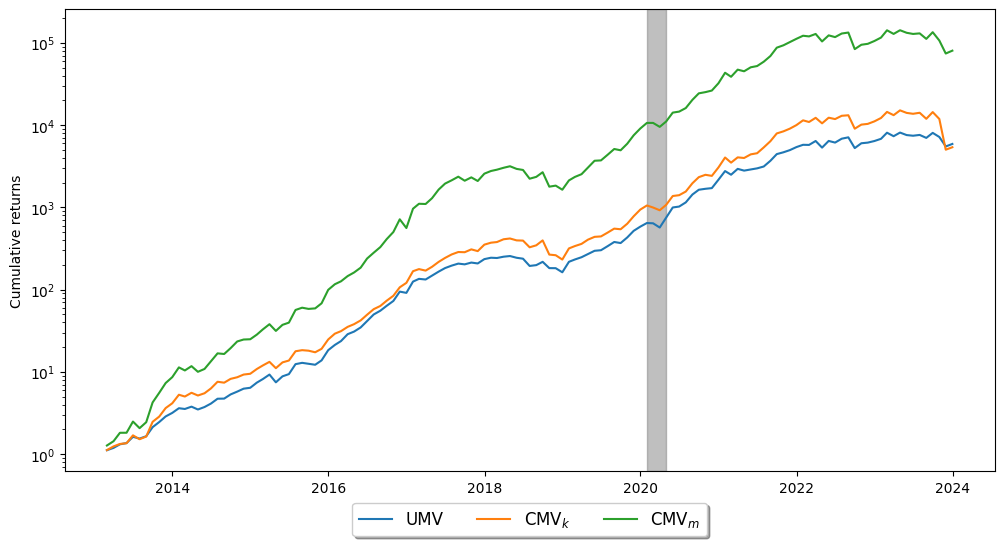

In [39]:
### Extracting the data from the database
conn = sqlite3.connect('Data/data.db')

factor_ret_m = pd.read_sql('SELECT * FROM factors_monthly', conn).set_index('Date').drop(columns='rf')
volatility = pd.read_sql('SELECT * FROM volatility', conn).set_index('Date')

conn.close()

### Making sure all the data is in the same format
factor_ret_m.index = pd.to_datetime(factor_ret_m.index)
volatility.index = pd.to_datetime(volatility.index)

### Fixing the index of the factor_ret_m
factor_ret_m = factor_ret_m.loc[volatility.index]

### Restricing the data to the period we want
factor_ret_m = factor_ret_m.loc['2003':]
volatility = volatility.loc['2003':]

### Calculating the optimal c for each factor
c = pd.DataFrame(columns=factor_ret_m.columns)
c.loc['c_fac', :] = np.nan
c.loc['c_mkt', :] = np.nan

for factor in factor_ret_m.columns:
    def obj_func(c):
        vol_timed = (c / volatility[factor]).shift(1) * factor_ret_m[factor]
        return (vol_timed.std() - factor_ret_m.iloc[1:,][factor].std())**2

    res = minimize(obj_func, 0.1)
    c.loc['c_fac', factor] = res.x[0]

for factor in factor_ret_m.columns:
    def obj_func(c):
        vol_timed = (c / volatility['VW']).shift(1) * factor_ret_m[factor]
        return (vol_timed.std() - factor_ret_m.iloc[1:,][factor].std())**2

    res = minimize(obj_func, 0.1)
    c.loc['c_mkt', factor] = res.x[0]

### Getting the volatility timed returns
r_sigma_k, r_sigma_m = pd.DataFrame(index=factor_ret_m.index, columns=factor_ret_m.columns), pd.DataFrame(index=factor_ret_m.index, columns=factor_ret_m.columns)

for factor in factor_ret_m.columns:
    r_sigma_k[factor] = (c.loc['c_fac', factor] / volatility[factor]).shift(1) * factor_ret_m[factor]
    r_sigma_m[factor] = (c.loc['c_mkt', factor] / volatility['VW']).shift(1) * factor_ret_m[factor]

### Dropping the first row in all of our returns
r_sigma_k = r_sigma_k.iloc[1:,]
r_sigma_m = r_sigma_m.iloc[1:,]
r = factor_ret_m.iloc[1:,]

### Defining the starting window size
window = 120

### Creating a place to store the returns
MV = pd.DataFrame(columns=[['UMV', 'CMV_k', 'CMV_m']], index=r.index).iloc[window:,]
MV_is = pd.DataFrame(columns=[['UMV', 'CMV_k', 'CMV_m']], index=r.index).iloc[window:,]

### Getting the data we need for the expanding window
data_o = r
data_m = pd.concat([r, r_sigma_m], axis=1)
data_k = pd.concat([r, r_sigma_k], axis=1)

### Getting the in-sample weights
w_o_is = ptf_weights(data_o.iloc[window:,], negative=False, type='MVP', gamma = 5, wanted_weight='None')
w_m_is = ptf_weights(data_m.iloc[window:,], negative=False, type='MVP', gamma = 5, wanted_weight='None')
w_k_is = ptf_weights(data_k.iloc[window:,], negative=False, type='MVP', gamma = 5, wanted_weight='None')

### Getting the in-sample returns
MV_is.loc[:, 'UMV'] = (w_o_is * data_o.iloc[window:,]).sum(axis=1)
MV_is.loc[:, 'CMV_m'] = (w_m_is * data_m.iloc[window:,]).sum(axis=1)
MV_is.loc[:, 'CMV_k'] = (w_k_is * data_k.iloc[window:,]).sum(axis=1)

### Running the loop
for i in range(window, len(r)):
    ## Getting the weights
    w_o = ptf_weights(data_o.iloc[:i,], negative=False, type='MVP', gamma = 5, wanted_weight='None')
    w_m = ptf_weights(data_m.iloc[:i,], negative=False, type='MVP', gamma = 5, wanted_weight='None')
    w_k = ptf_weights(data_k.iloc[:i,], negative=False, type='MVP', gamma = 5, wanted_weight='None')

    ## Getting the returns
    MV.loc[r.index[i], 'UMV'] = (w_o * r.iloc[i,]).sum()
    MV.loc[r.index[i], 'CMV_k'] = (w_m * data_k.iloc[i,]).sum()
    MV.loc[r.index[i], 'CMV_m'] = (w_k * data_m.iloc[i,]).sum()

### Getting the p-values
p_values = pd.DataFrame(columns=MV.columns, index=['In-Sample', 'Out-of-Sample'])

### Number of simulations
n_boot = 10000

### Getting the data we need
data = pd.concat([MV, MV_is], axis=1)

### Loop for in-sample or out-of-sample
for s in [0,1]:

    ### Loop for factor or market
    for f in [1,2]:

        ## Creating a list to store the differences
        diff = []

        ## Loop for the bootstrap
        for i in range(n_boot):
            # Getting the bootstrapped returns
            boot = stationary_bootstrap(np.array(data.iloc[:, [(0+s*3), (f+s*3)]].astype(float)), 5, len(data))

            # Adding the difference to the list
            diff.append(sharpes_ratio(boot[:,0]) - sharpes_ratio(boot[:,1]))

        ## Getting the p-value
        p_values.iloc[s,f] = (np.sum(np.array(diff) > 0) / (len(diff)))

### Getting the alphas
X = MV['UMV'].astype(float)
X = sm.add_constant(X)
y = MV['CMV_k'].astype(float)
model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':1})
alpha_k = model.params['const']
tstat_alpha_k = model.tvalues['const']

y = MV['CMV_m'].astype(float)
model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':1})
alpha_m = model.params['const']
tstat_alpha_m = model.tvalues['const']

### Creating  a latex table
latex = pd.DataFrame(columns=['UMV', 'CMV_k', 'CMV_m'], index=['Mean', 'Standard deviation', 'Sharpe ratio', 'p-value', 'alpha', 't(alpha)'])

latex.loc['Mean', :] = MV.mean().values * 12
latex.loc['Standard deviation', :] = MV.std().values * np.sqrt(12)
latex.loc['Sharpe ratio', :] = sharpes_ratio(MV).values
latex.loc['p-value', 'CMV_k'] = p_values.iloc[1,1]
latex.loc['p-value', 'CMV_m'] = p_values.iloc[1,2]
latex.loc['alpha', 'CMV_k'] = alpha_k * 12 * 100
latex.loc['alpha', 'CMV_m'] = alpha_m * 12 * 100
latex.loc['t(alpha)', 'CMV_k'] = tstat_alpha_k
latex.loc['t(alpha)', 'CMV_m'] = tstat_alpha_m

latex_all_period.loc['Sharpe ratio (2013-2023)', :] = sharpes_ratio(MV).values
latex_all_period.loc['p-value (2013-2023)', 'CMV_k'] = p_values.iloc[1,1]
latex_all_period.loc['p-value (2013-2023)', 'CMV_m'] = p_values.iloc[1,2]
latex_all_period.loc['alpha (2013-2023)', 'CMV_k'] = alpha_k * 12 * 100
latex_all_period.loc['alpha (2013-2023)', 'CMV_m'] = alpha_m * 12 * 100
latex_all_period.loc['t(alpha) (2013-2023)', 'CMV_k'] = tstat_alpha_k
latex_all_period.loc['t(alpha) (2013-2023)', 'CMV_m'] = tstat_alpha_m

#print(latex.to_latex(float_format="%.3f", na_rep=""))
print(latex)

### Plotting cumulative returns for all the 3 portfolios in MV
plt.figure(figsize=(12, 6))
plt.plot((1 + MV).cumprod())
plt.ylabel('Cumulative returns')
plt.legend(['UMV', r'CMV$_{k}$', r'CMV$_{m}$'], loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=3, fontsize='large')
plt.yscale('log')

recessions = [
    ('2020-02-01', '2020-04-30')
]

# Add grey fields for recessions
for start, end in recessions:
    plt.axvspan(start, end, color='grey', alpha=0.5)

plt.show()

In [40]:
print(latex_all_period.to_latex(na_rep='', float_format="%.3f"))

\begin{tabular}{llll}
\toprule
 & UMV & CMV_k & CMV_m \\
\midrule
Sharpe ratio (1993-2003) & 1.530 & 1.542 & 1.515 \\
p-value (1993-2003) &  & 0.276 & 0.040 \\
alpha (1993-2003) &  & 2.994 & 2.100 \\
t(alpha) (1993-2003) &  & 1.106 & 0.771 \\
Sharpe ratio (2003-2013) & 1.755 & 1.584 & 1.558 \\
p-value (2003-2013) &  & 0.961 & 0.956 \\
alpha (2003-2013) &  & 6.231 & -2.085 \\
t(alpha) (2003-2013) &  & 0.895 & -0.504 \\
Sharpe ratio (2013-2023) & 2.210 & 1.931 & 2.094 \\
p-value (2013-2023) &  & 0.170 & 0.054 \\
alpha (2013-2023) &  & -4.987 & 5.000 \\
t(alpha) (2013-2023) &  & -0.494 & 0.765 \\
\bottomrule
\end{tabular}

